In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Tengai.dataset import AirQuality
from Tengai.preprocessing import clustering_data,detect_outlier_zscore,detect_pdq_different
from Tengai.visual_series import (lineplot_features,lineplot_resample_feature,
                                  average_generating_barplot,visualize_adfuller_results,
                                  plotting_different)
import statsmodels.api as sm
from Tengai.model import grangers_causation_matrix,custom_train_test_split

## Load Data

In [2]:
data = AirQuality(-8.2325,114.3576)
data

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01 00:00:00,38.5,26.7,716.0,9.6,47.0,0.36,0.0
1,2023-01-01 01:00:00,31.1,21.4,624.0,7.8,60.0,0.34,0.0
2,2023-01-01 02:00:00,26.3,17.9,492.0,5.2,79.0,0.31,0.0
3,2023-01-01 03:00:00,24.2,16.4,347.0,2.5,98.0,0.29,0.0
4,2023-01-01 04:00:00,23.1,15.7,295.0,1.5,102.0,0.32,0.0
...,...,...,...,...,...,...,...,...
7195,2023-10-27 19:00:00,25.6,17.6,486.0,7.2,21.0,0.38,1.0
7196,2023-10-27 20:00:00,25.1,17.3,461.0,6.5,20.0,0.38,1.0
7197,2023-10-27 21:00:00,26.3,18.2,429.0,5.8,22.0,0.38,1.0
7198,2023-10-27 22:00:00,29.6,20.5,384.0,5.0,30.0,0.39,1.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   7200 non-null   datetime64[ns]
 1   pm10                   7200 non-null   float64       
 2   pm2_5                  7200 non-null   float64       
 3   carbon_monoxide        7200 non-null   float64       
 4   nitrogen_dioxide       7200 non-null   float64       
 5   ozone                  7200 non-null   float64       
 6   aerosol_optical_depth  7200 non-null   float64       
 7   dust                   7200 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 450.1 KB


# EDA

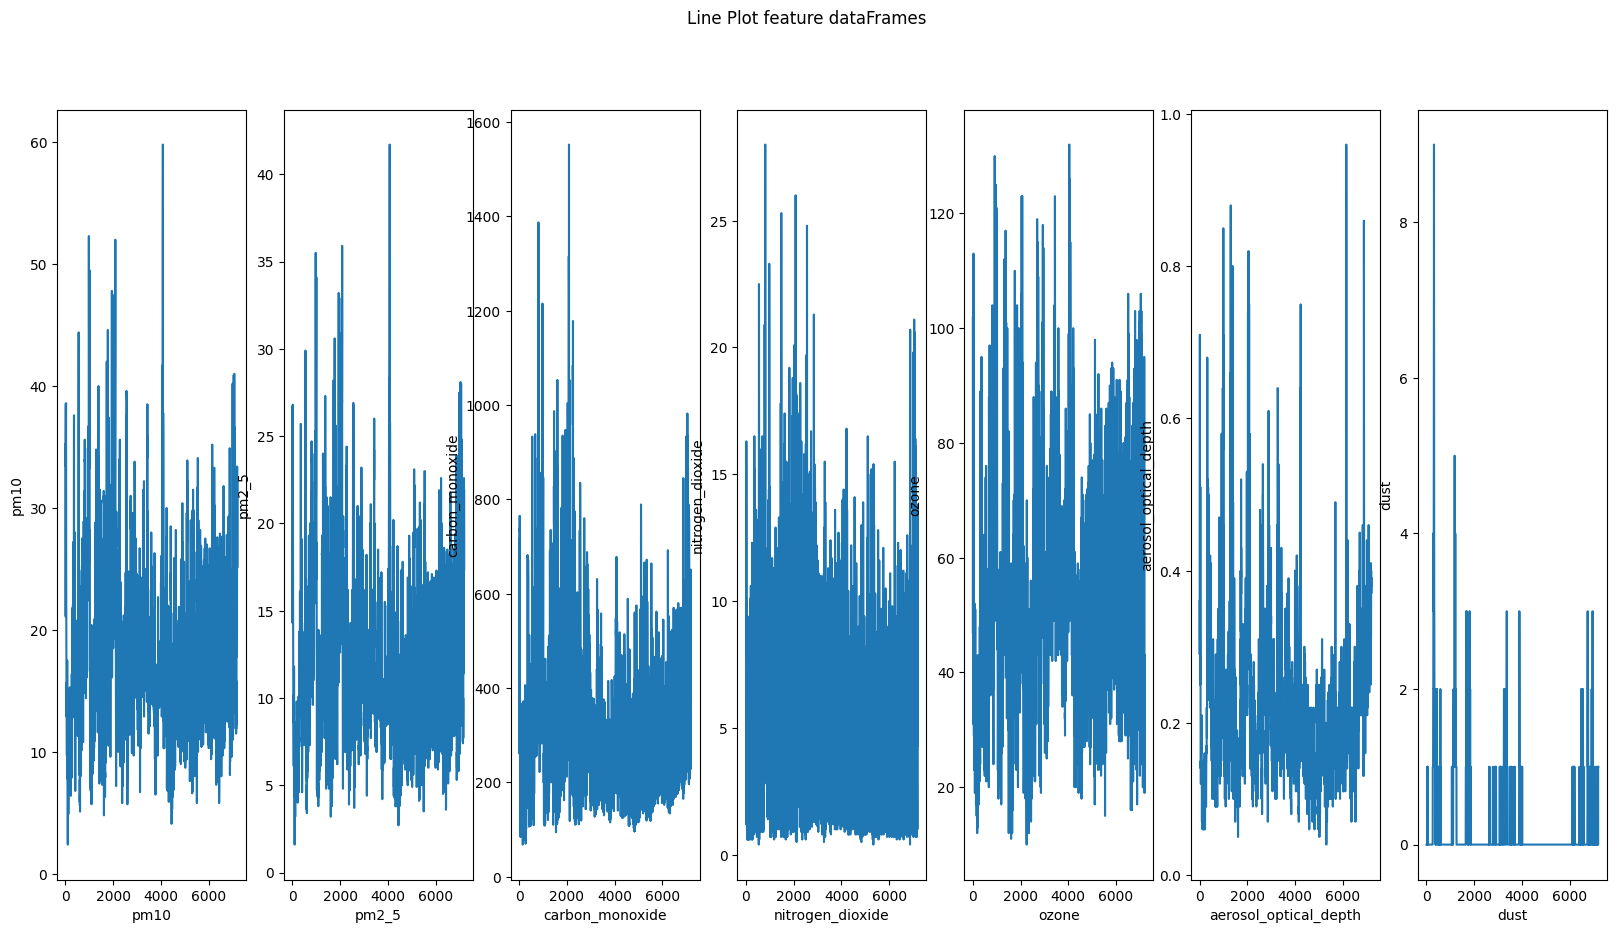

In [4]:
lineplot_features(data.iloc[:,1:],size=(20,10))

### Resample Line Plot

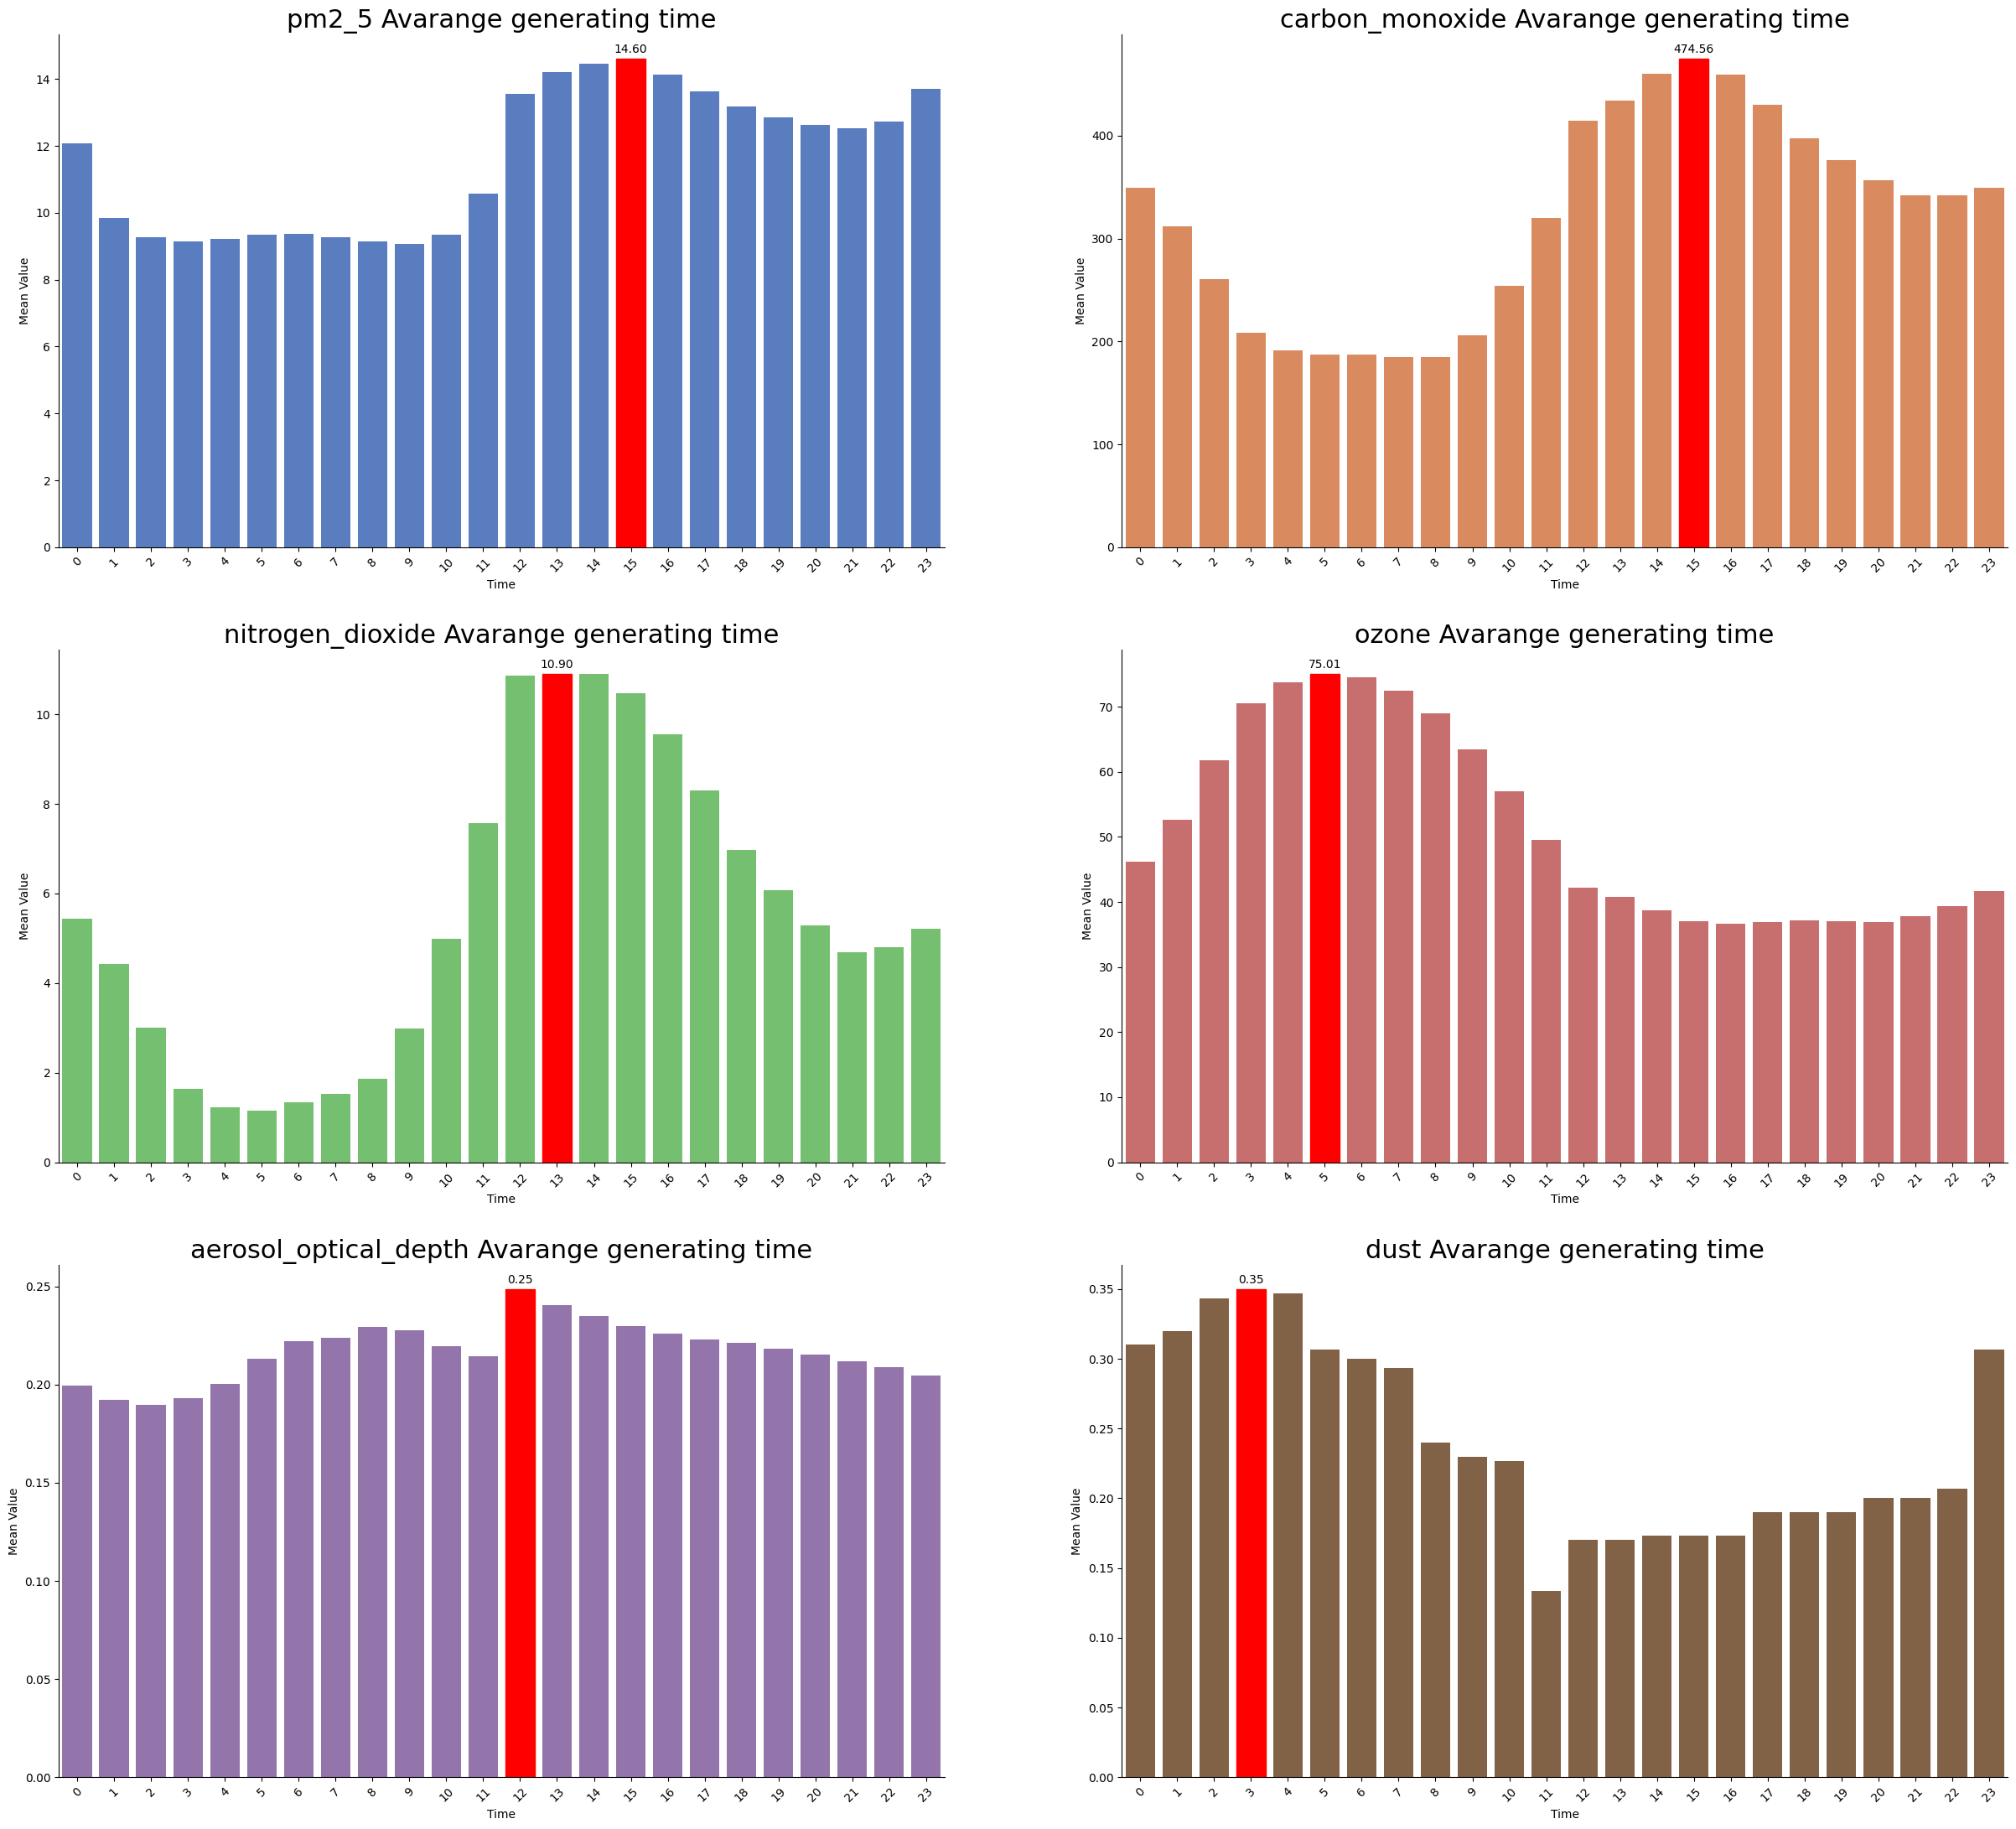

In [5]:
average_generating_barplot(data,on_feat="time")

### Linear Resample feature

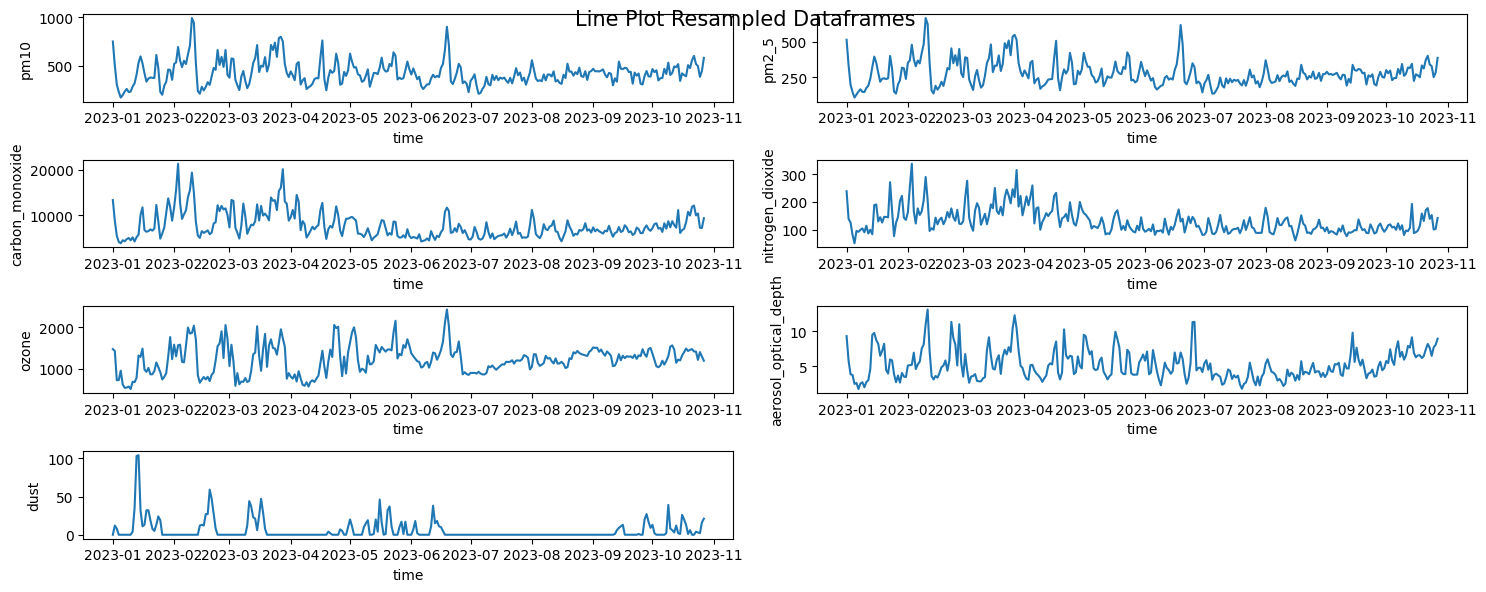

In [6]:
lineplot_resample_feature(data,"time","1D")

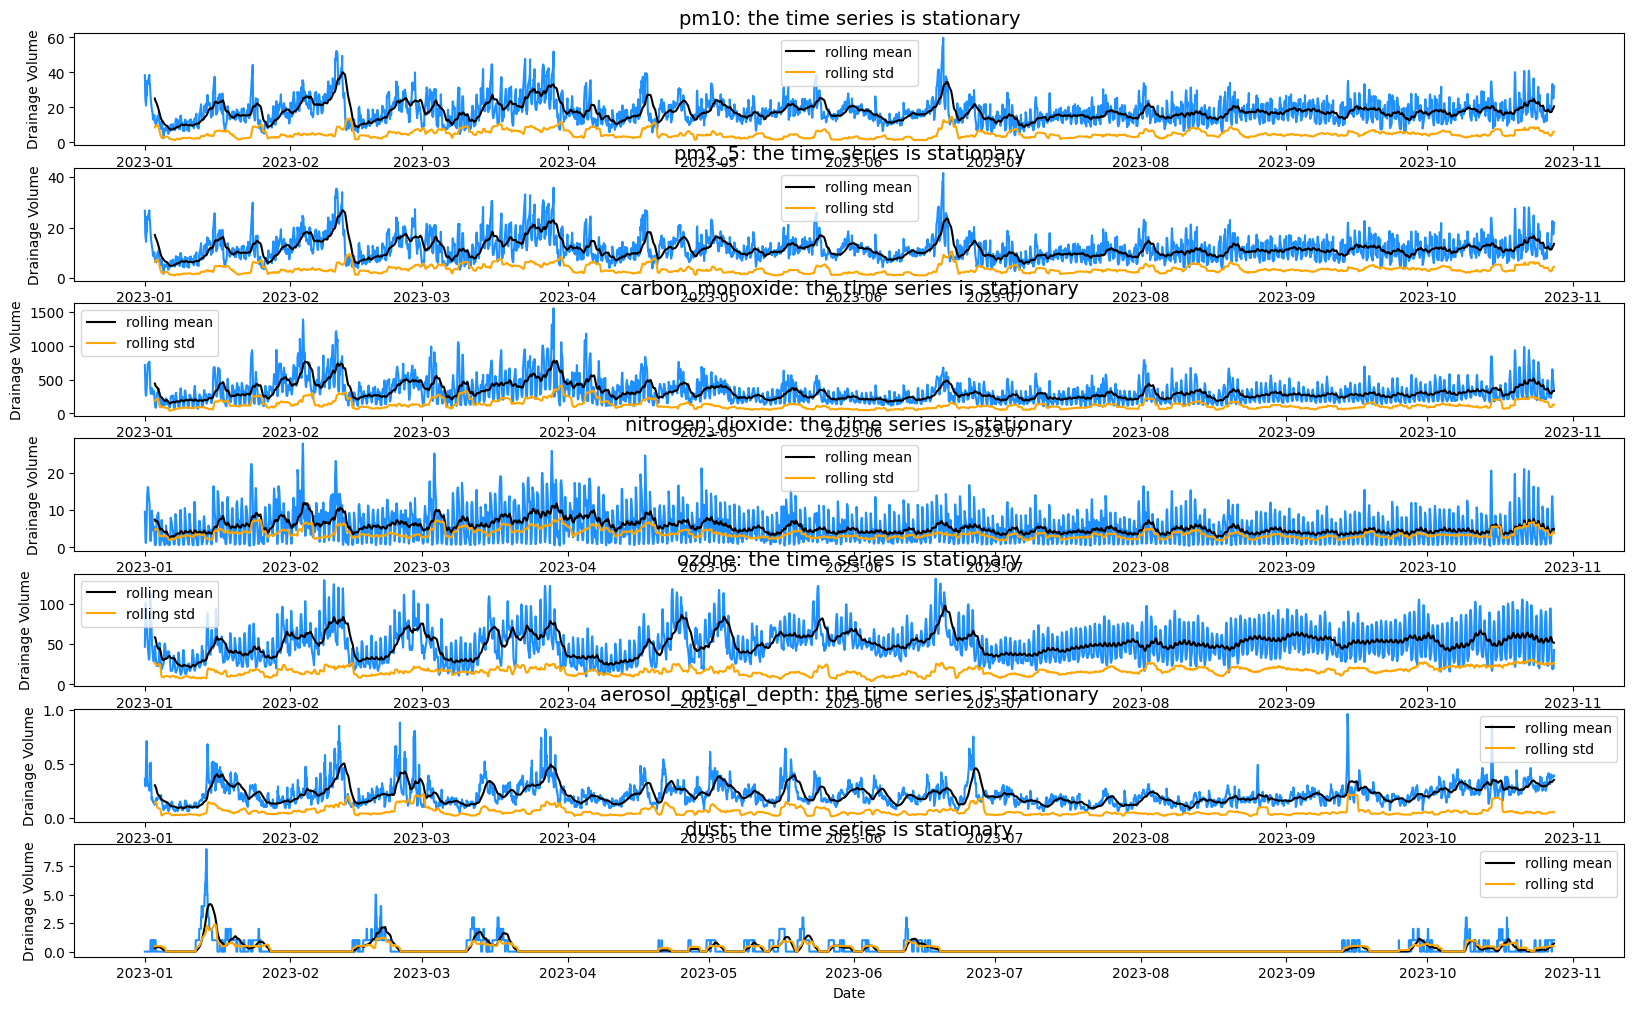

In [7]:
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pandas as pd

def plot_rolling_statistics(df: pd.DataFrame, rolling_window=7):
    """
    Plot rolling statistics for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        rolling_window (int, optional): Rolling window size for mean and std calculations. Defaults to 7.

    Returns:
        None: This function displays the plot but doesn't return any value.
    """
    numerical_features = df.select_dtypes(include=np.number).columns
    f, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(20, 12))
    
    for i, feat in enumerate(numerical_features):
        sns.lineplot(x=df['time'], y=df[feat], ax=ax[i], color='dodgerblue')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).mean(), ax=ax[i], color='black', label='rolling mean')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).std(), ax=ax[i], color='orange', label='rolling std')
        
        # Calculate ADF test results
        adf_result = adfuller(df[feat], autolag="AIC")
        if adf_result[1] <= 0.05:
            ax[i].set_title(f'{feat}: the time series is stationary', fontsize=14)
        else:
            ax[i].set_title(f'{feat}: the time series is non-stationary', fontsize=14)

        # Add labels and legend
        ax[i].set_xlabel('Date')
        ax[i].set_ylabel('Drainage Volume')
        ax[i].legend()

    # Show the plot
    plt.show()

# Example usage:
plot_rolling_statistics(data,52)

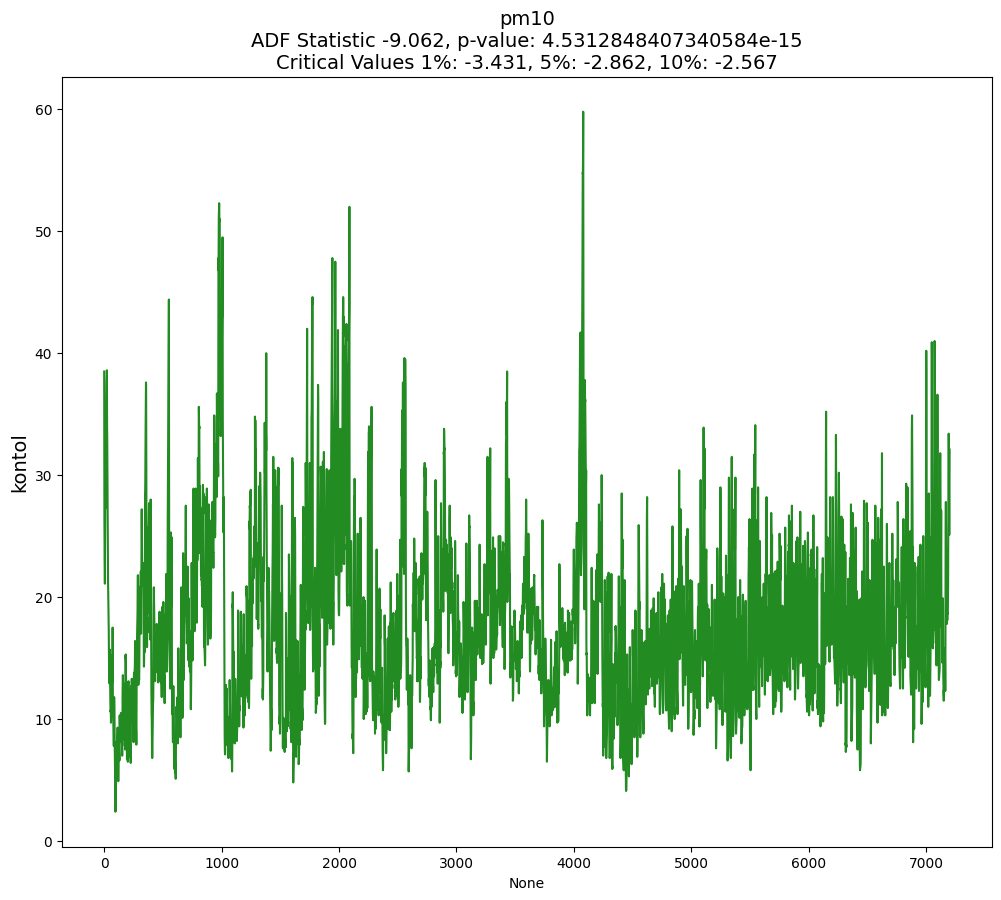

In [8]:
visualize_adfuller_results(data,"pm10","kontol")

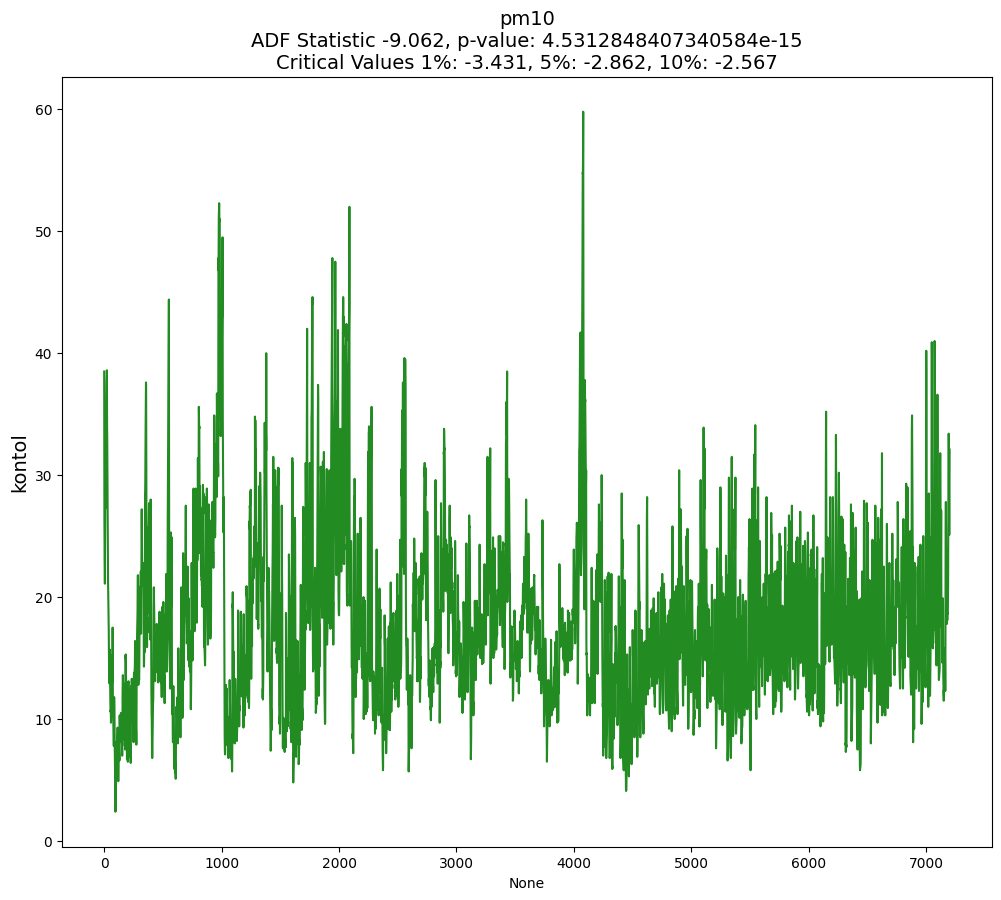

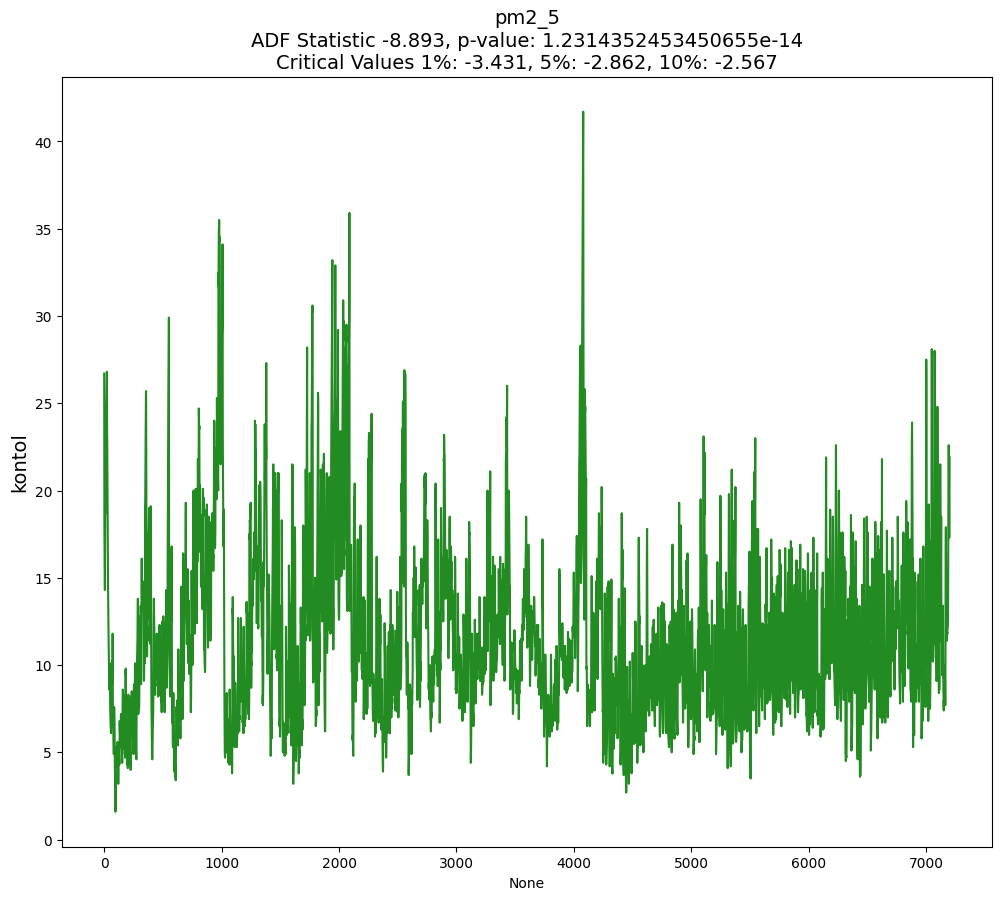

In [9]:
visualize_adfuller_results(data,["pm10","pm2_5"],"kontol")

## Data Preprocessing

#### - For Clustering Model

In [10]:
data_cluster = data.set_index("time").resample("D").mean()
data_cluster.reset_index(inplace=True)
# droping `time` feature
data_cluster.drop(["time","dust"],axis=1,inplace=True)
data_cluster.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth
0,31.179167,21.466667,554.750000,9.929167,61.458333,0.387083
1,20.875000,14.025000,365.791667,5.804167,59.625000,0.241667
2,12.716667,8.241667,226.166667,5.237500,30.375000,0.160000
3,9.516667,6.112500,169.750000,3.404167,30.541667,0.156667
4,7.116667,4.491667,157.416667,2.137500,39.958333,0.103333


In [11]:
no_outliers_count = 0

for feat in data_cluster.columns:
    outlier = detect_outlier_zscore(data_cluster[feat])
    if any(outlier[0]):
        print(f"Outlier of {feat} is in index: {outlier[0]}")
        data_cluster[feat] = detect_outlier_zscore(data_cluster[feat], change_outlier=True)
    else:
        no_outliers_count += 1

if no_outliers_count == len(data_cluster.columns):
    print("No outliers found in any feature. Stopping iteration.")


Outlier of pm10 is in index: [ 40  41 169]
Outlier of pm2_5 is in index: [ 40  41  85 169]
Outlier of carbon_monoxide is in index: [33 40 86]
Outlier of nitrogen_dioxide is in index: [22 33 40 61 86]
Outlier of ozone is in index: [169]
Outlier of aerosol_optical_depth is in index: [41 85]


### Scaling Data

In [12]:
from sklearn.preprocessing import StandardScaler
pre_data = StandardScaler().fit_transform(data_cluster)

#### Modeling Data

In [13]:
from Tengai.model import dbscan_grid_search
_,_,_,best_parameter=dbscan_grid_search(pre_data)
best_parameter

(0.8, 3)

In [14]:
from sklearn.cluster import DBSCAN,KMeans
cluster = DBSCAN(eps=best_parameter[0],min_samples=best_parameter[1])
best_clusters = cluster.fit_predict(X=pre_data)

The best number of clusters is: 6
Cluster Assignments:
Noise points: 76
Cluster 0: 208 data points
Cluster 1: 3 data points
Cluster 2: 4 data points
Cluster 3: 3 data points
Cluster 4: 3 data points
Cluster 5: 3 data points


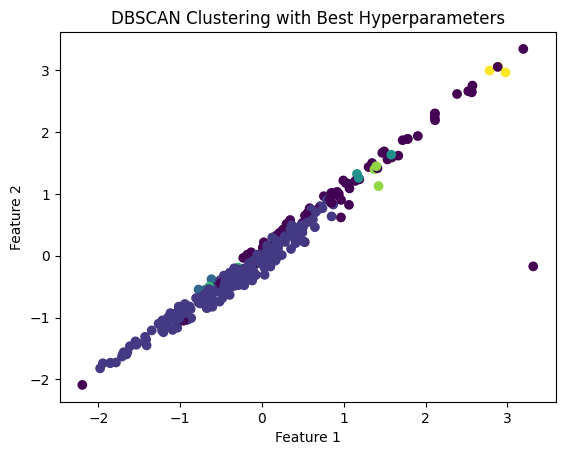

In [15]:
best_n_clusters = len(np.unique(best_clusters)) - 1
print(f"The best number of clusters is: {best_n_clusters}")

# Example: Print cluster assignments
print("Cluster Assignments:")
for label in np.unique(best_clusters):
    if label == -1:
        print(f"Noise points: {np.sum(best_clusters == label)}")
    else:
        print(f"Cluster {label}: {np.sum(best_clusters == label)} data points")

# Example: Visualize the clusters (you may use a suitable visualization library)
# This depends on the structure of your data and how you want to visualize it.
# For example, you can create a scatter plot using Matplotlib or Seaborn.
# Here's a basic example using Matplotlib:
import matplotlib.pyplot as plt
plt.scatter(pre_data[:, 0], pre_data[:, 1], c=best_clusters)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Best Hyperparameters')
plt.show()

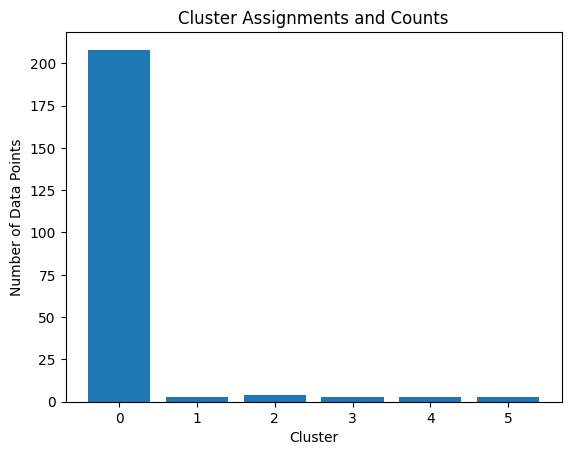

In [16]:
unique_clusters, cluster_counts = np.unique(best_clusters, return_counts=True)
unique_clusters = unique_clusters[1:]
cluster_counts = cluster_counts[1:]
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Assignments and Counts')
plt.show()

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


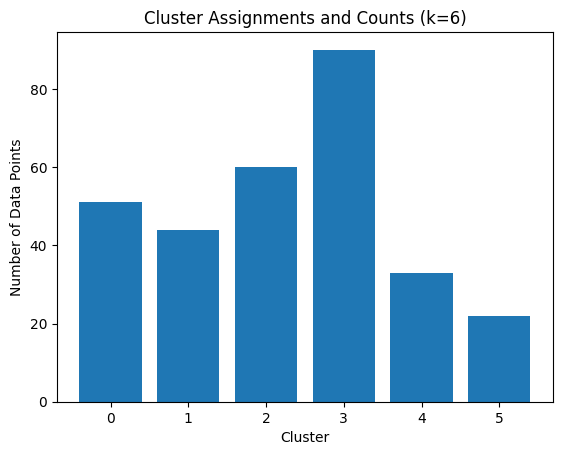

In [17]:
kmeans = KMeans(n_clusters=6,random_state=42,init="random",max_iter=100)
cluster_assignments = kmeans.fit_predict(pre_data)

# Count the number of data points in each cluster
unique_clusters, cluster_counts = np.unique(cluster_assignments, return_counts=True)

# Create a bar plot
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title(f'Cluster Assignments and Counts (k={6})')
plt.show()

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Evaluate K-Means clustering using Silhouette Score and Davies-Bouldin Index
kmeans_silhouette = silhouette_score(pre_data, cluster_assignments)
kmeans_db_index = davies_bouldin_score(pre_data, cluster_assignments)

# Evaluate DBSCAN clustering using Silhouette Score and Davies-Bouldin Index
dbscan_silhouette = silhouette_score(pre_data, best_clusters)
dbscan_db_index = davies_bouldin_score(pre_data, best_clusters)


In [19]:
print(f'K-Means Silhouette Score: {kmeans_silhouette}')
print(f'K-Means Davies-Bouldin Index: {kmeans_db_index}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
print(f'DBSCAN Davies-Bouldin Index: {dbscan_db_index}')

K-Means Silhouette Score: 0.24045111696969174
K-Means Davies-Bouldin Index: 1.244569751237666
DBSCAN Silhouette Score: 0.05167801054036719
DBSCAN Davies-Bouldin Index: 1.5579090117969876


In [20]:
import joblib
with open("cluster_mode.pkl","wb") as f:
    joblib.dump(kmeans,f)

In [21]:
load_cluster = joblib.load("cluster_mode.pkl")

In [22]:
with open("cluster_mode.pkl", "rb") as f:
    cluster_assignments = joblib.load(f)

In [23]:
cluster_assignments = cluster_assignments.predict(pre_data)

In [24]:
cluster_assignments

array([5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3,
       1, 4, 0, 0, 0, 4, 4, 1, 3, 1, 5, 1, 5, 2, 4, 1, 5, 5, 1, 5, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 4, 2, 5, 1, 1, 4, 1, 2, 3, 5, 1, 0, 0, 0, 4,
       4, 4, 0, 0, 4, 1, 1, 5, 4, 4, 1, 1, 4, 1, 5, 5, 5, 5, 5, 5, 1, 5,
       4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 0, 0, 0, 4, 4, 5, 5, 4, 0, 3,
       1, 2, 1, 5, 1, 3, 0, 2, 4, 4, 1, 1, 1, 1, 2, 3, 3, 3, 2, 2, 0, 3,
       3, 3, 3, 2, 1, 1, 2, 3, 2, 3, 1, 1, 3, 3, 3, 3, 2, 1, 2, 2, 2, 3,
       3, 2, 0, 0, 0, 3, 0, 2, 3, 3, 3, 3, 2, 1, 5, 2, 5, 3, 3, 3, 2, 1,
       1, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 4, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3,
       3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 0, 3, 2, 1, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 1, 5, 1, 1, 2, 2, 1])

In [25]:
label = {"good","fair","moderator","poor","very poor","Extremely poor"}
zipping = dict(zip(np.unique(kmeans.labels_),label))

In [26]:
import json
data_to_write = {str(key): value for key, value in zipping.items()}
with open("label_cluster.json","w") as f:
    json.dump(data_to_write,f)


In [27]:
with open('label_cluster.json', 'r') as file:
    # Load JSON data from the file
    label = json.load(file)

# Time Series Data preprocessing

In [28]:
times_series_df = data.set_index("time")
times_series_df = times_series_df.resample("D").mean().round(3)
times_series_df.reset_index(inplace=True)

In [29]:
times_series_df.head()

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
1,2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2,2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
3,2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
4,2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000


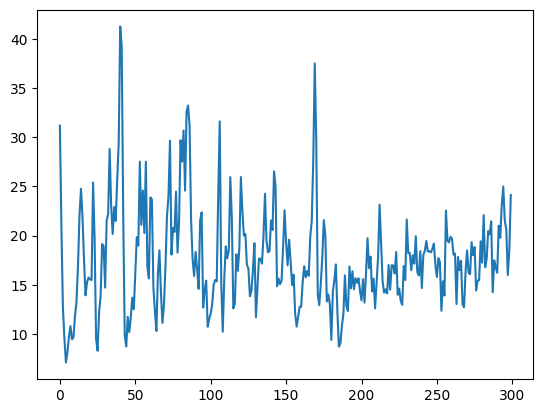

In [30]:
plt.plot(times_series_df["pm10"])

In [31]:
# check outlier
features = times_series_df.select_dtypes(include=np.number).columns
for feat in features:
    outliers = detect_outlier_zscore(times_series_df[feat])
    print(f"Outliers in {feat} are at indices: {outliers[0]}")

Outliers in pm10 are at indices: [ 40  41 169]
Outliers in pm2_5 are at indices: [ 40  41  85 169]
Outliers in carbon_monoxide are at indices: [33 40 86]
Outliers in nitrogen_dioxide are at indices: [22 33 40 61 86]
Outliers in ozone are at indices: [169]
Outliers in aerosol_optical_depth are at indices: [41 85]
Outliers in dust are at indices: [ 12  13  49  50  75 135]


In [32]:
# setting `time` feature be index
times_series_df.set_index("time",inplace=True)
times_series_df.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
time,,,,,,,
2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000


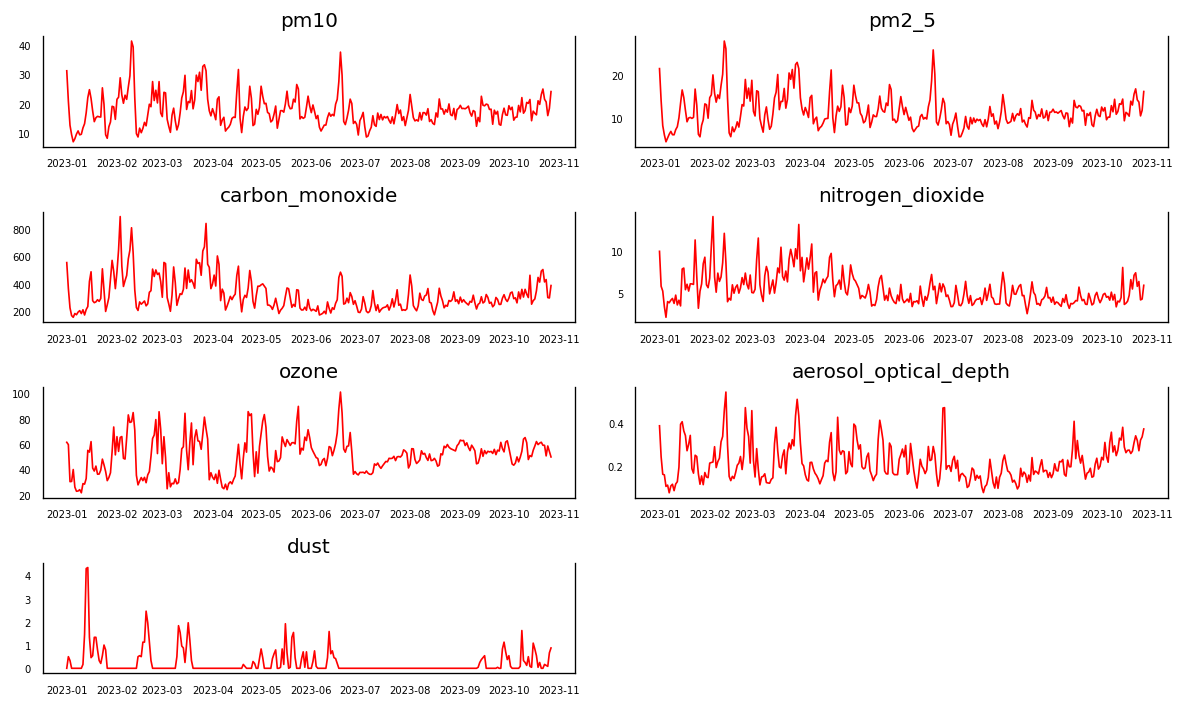

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(times_series_df.columns):
        data = times_series_df[times_series_df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(times_series_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    else:
        # Jika ada subplot yang tersisa, hilangkan sumbunya.
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [34]:
grangers_causation_matrix(data=times_series_df, variables = times_series_df.columns)

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  

,pm10_x,pm2_5_x,carbon_monoxide_x,nitrogen_dioxide_x,ozone_x,aerosol_optical_depth_x,dust_x
pm10_y,0.0000,0.3116,0.1902,0.0889,0.0246,0.0556,0.0309
pm2_5_y,0.1818,0.0000,0.1472,0.0709,0.0441,0.0690,0.0237
carbon_monoxide_y,0.0136,0.0127,0.0000,0.0001,0.0014,0.0242,0.1371
nitrogen_dioxide_y,0.0151,0.0094,0.0028,0.0000,0.1091,0.0052,0.0999
ozone_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0191,0.0108
aerosol_optical_depth_y,0.0549,0.0377,0.0251,0.0162,0.4287,0.0000,0.0005
dust_y,0.0189,0.0248,0.1070,0.4990,0.0172,0.0586,0.0000


from this,not all feature have relation with other feature
<br>

we want plotting different

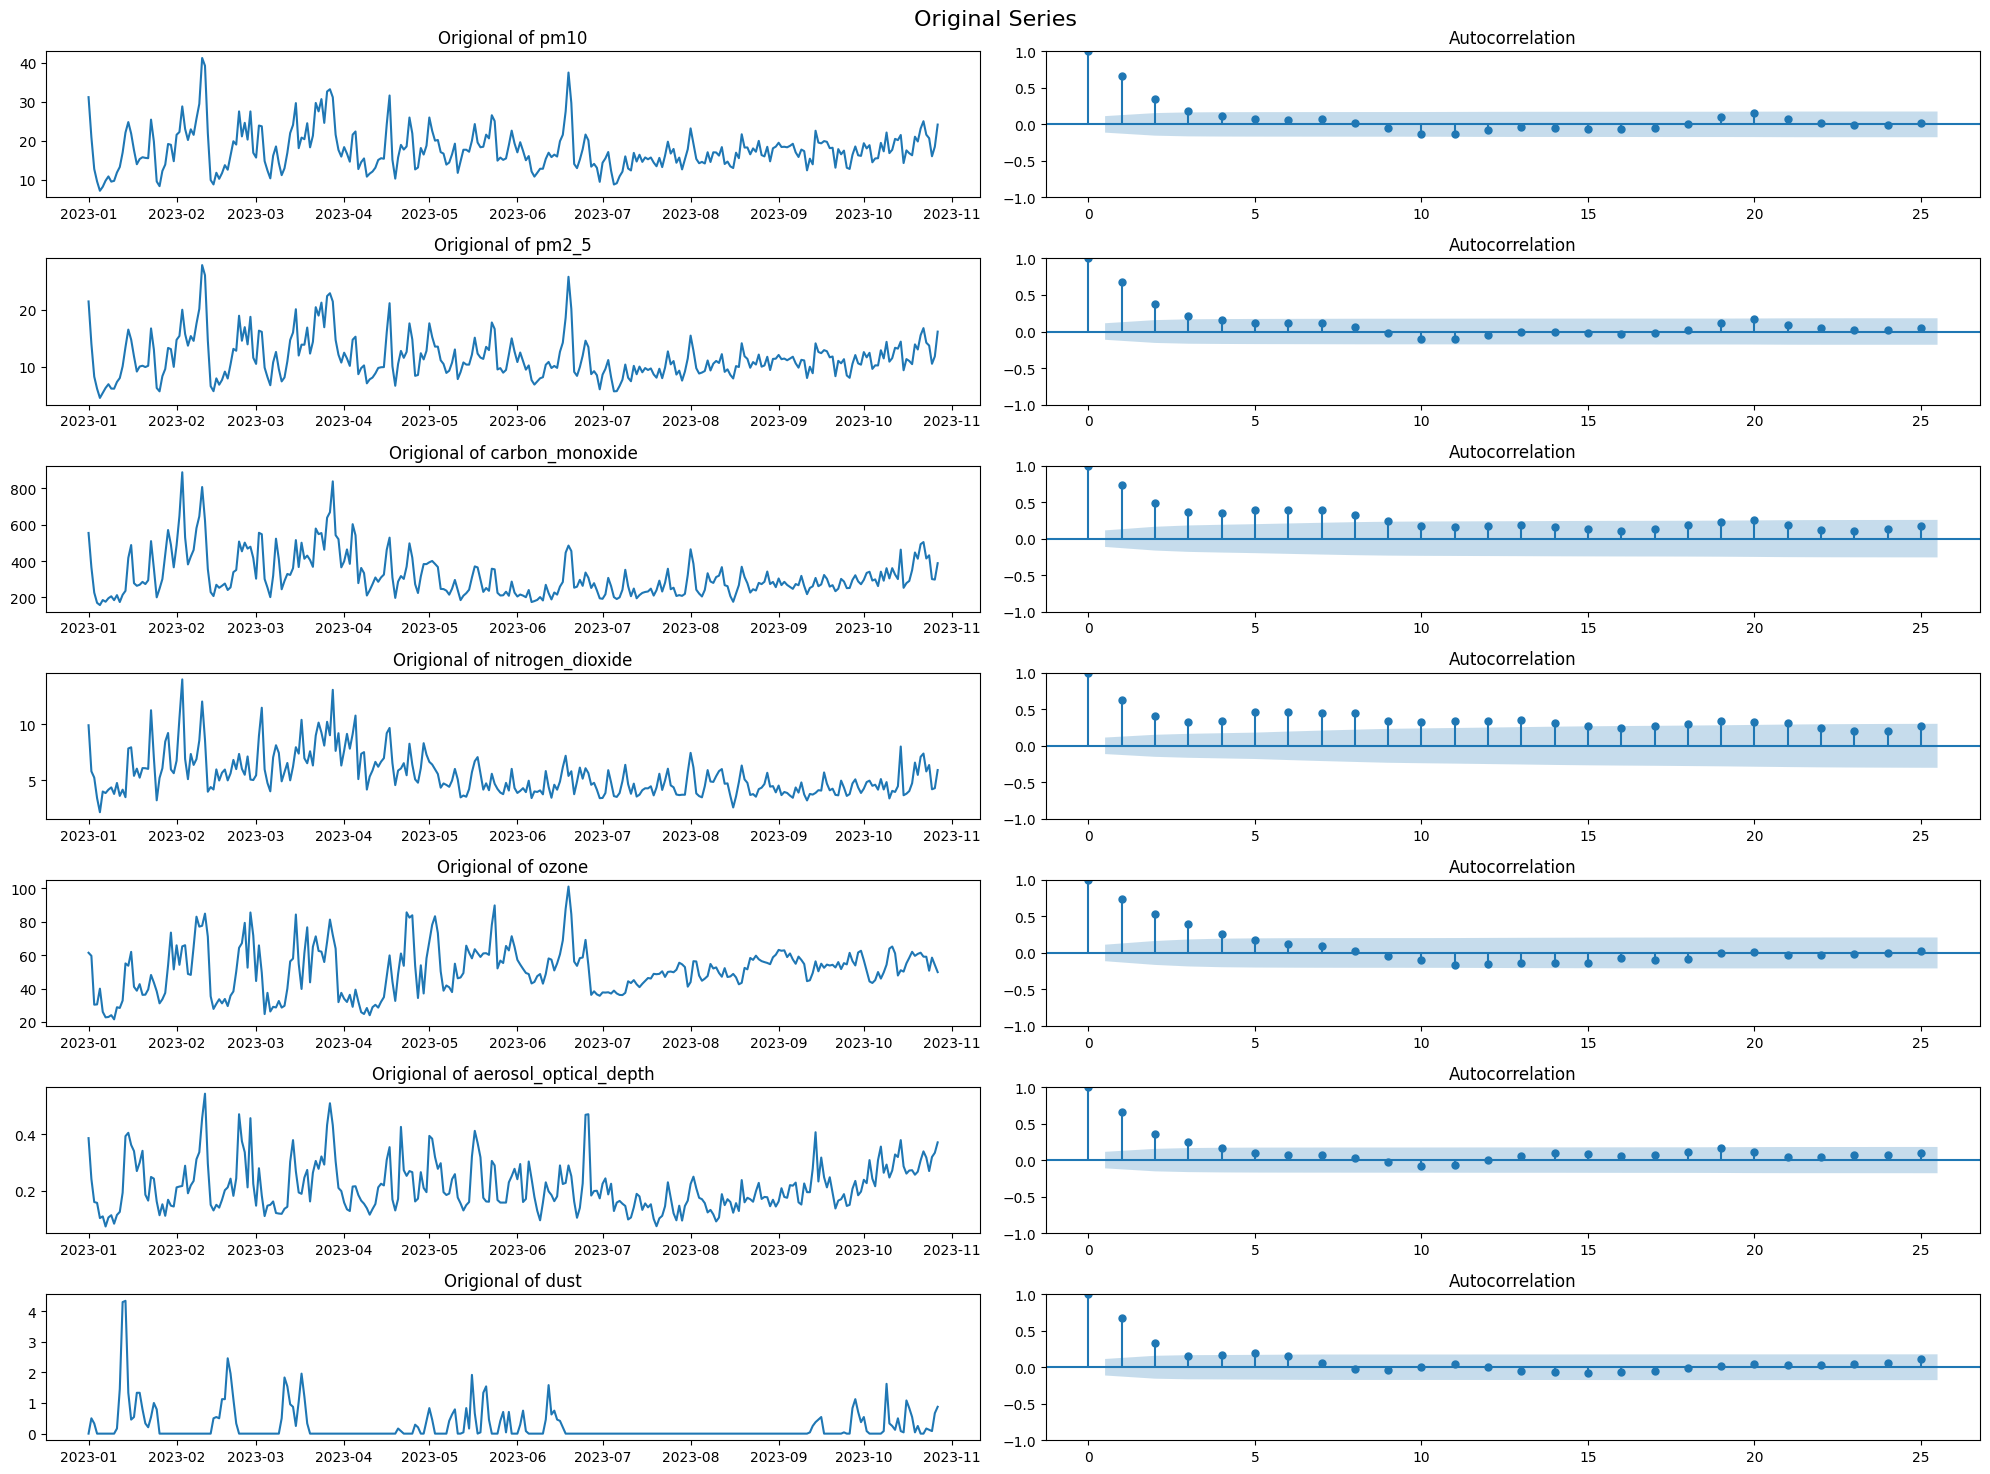

In [35]:
plotting_different(times_series_df,size=(20,15),
                   title="Original Series")

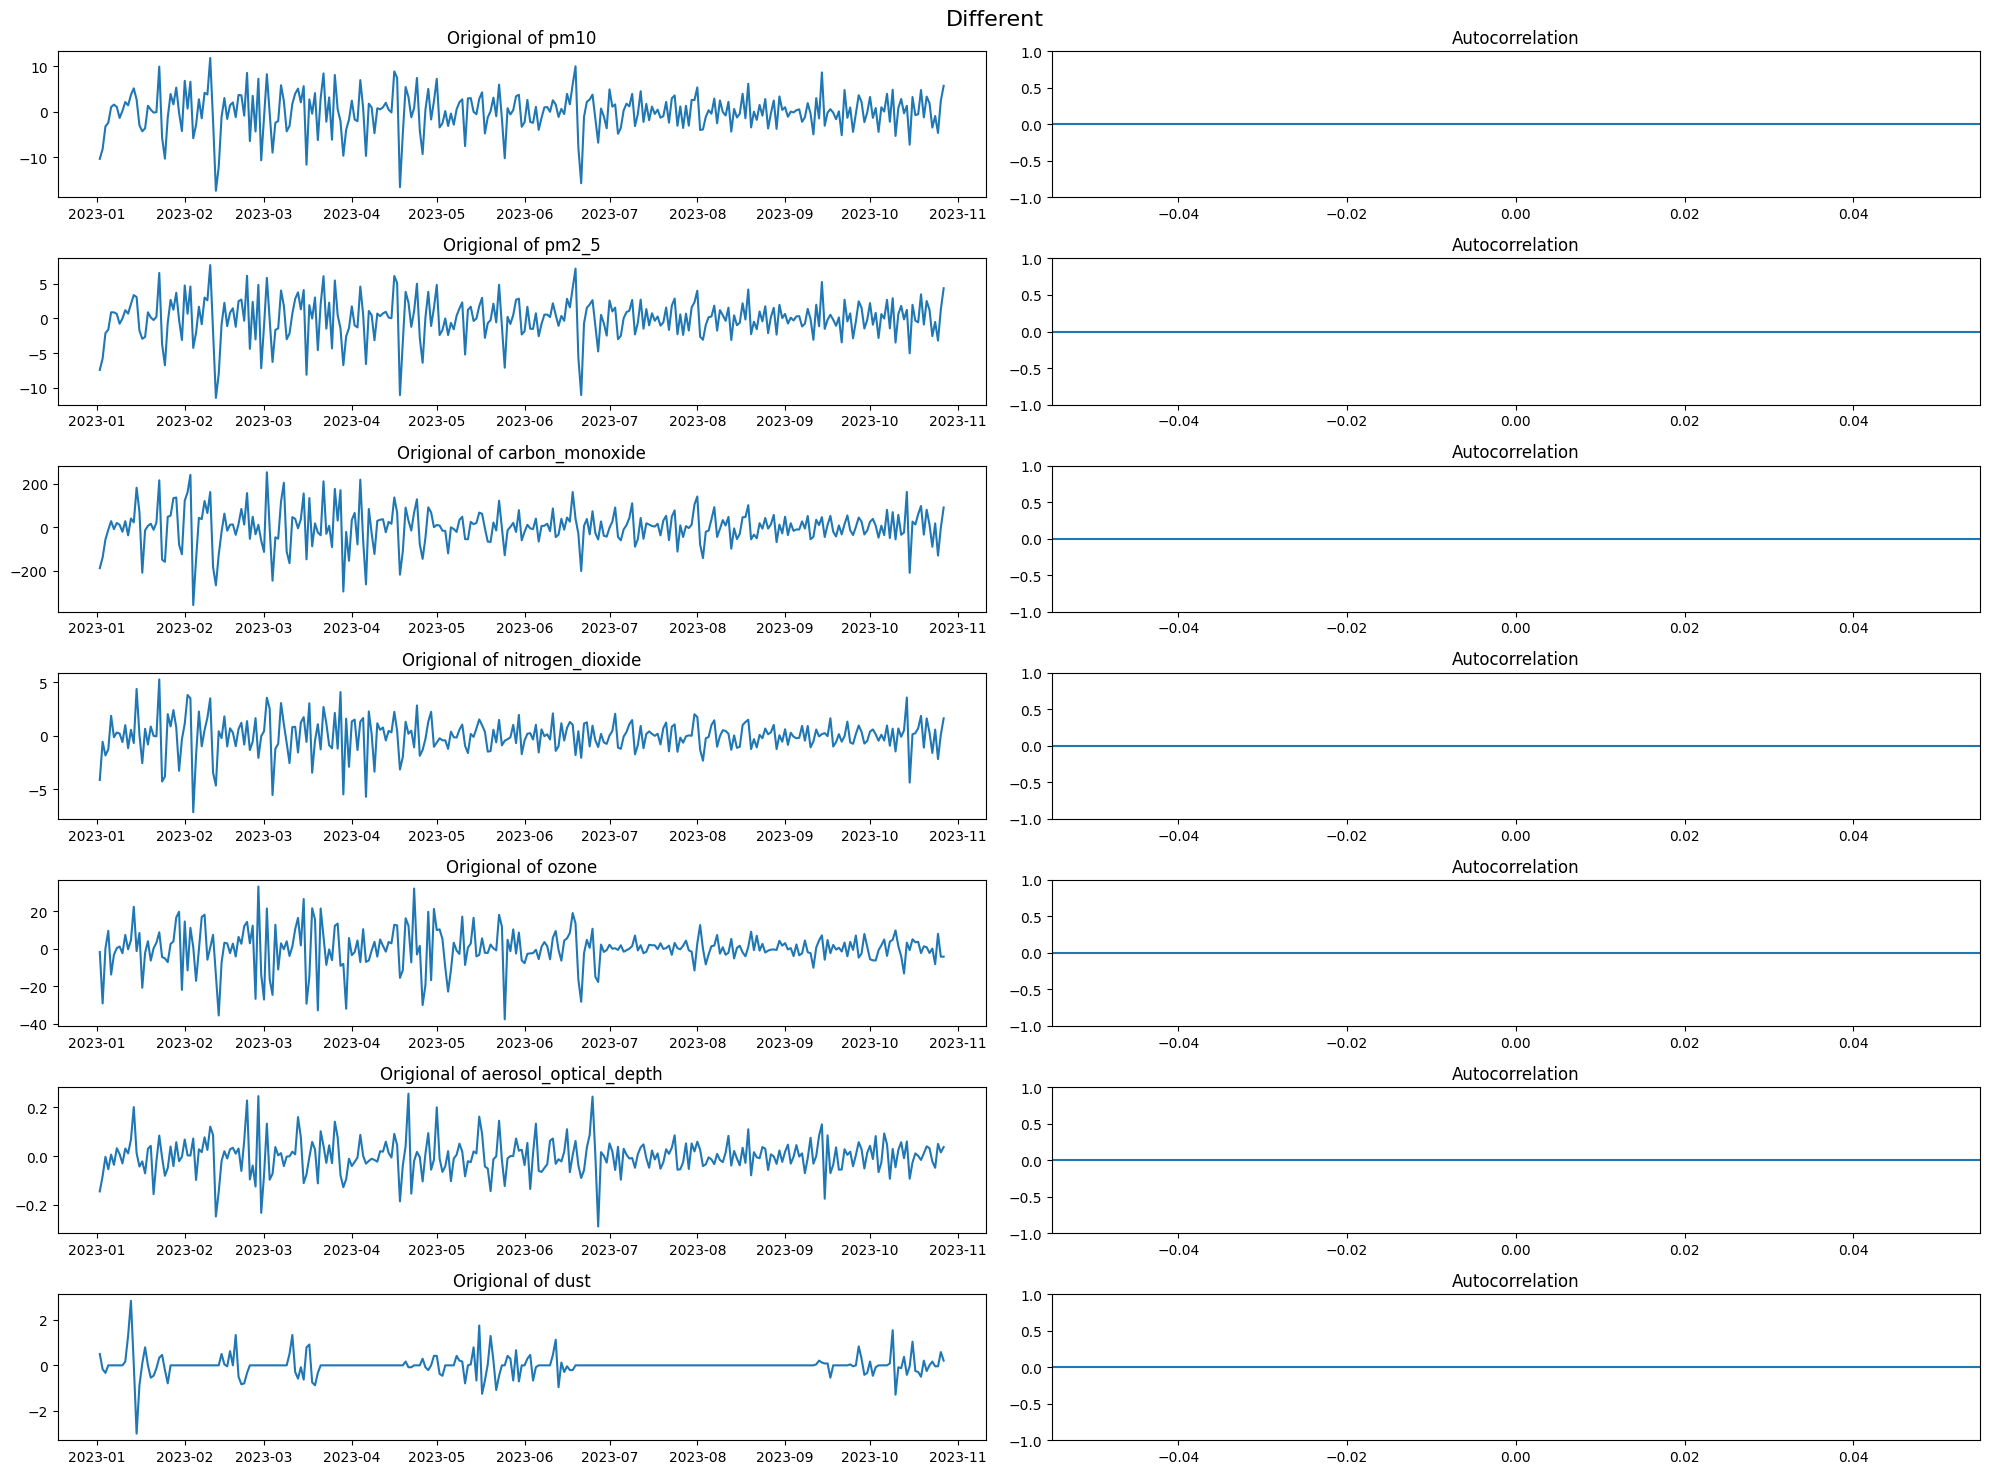

In [36]:
plotting_different(times_series_df.diff(),size=(20,15),
                   title="Different")

In [37]:
import statsmodels.api as sm
data_diff = times_series_df["pm10"].diff().dropna()
best_aic = np.inf
best_bic = np.inf
best_p = 0
best_q = 0

# Define a range for p and q
p_range = range(0, 4)  # Example range for p
q_range = range(0, 4)  # Example range for q

for p in p_range:
    for q in q_range:
        model = sm.tsa.ARIMA(data_diff, order=(p, 1, q))
        results = model.fit()
        aic = results.aic
        bic = results.bic

        if aic < best_aic and bic < best_bic:
            best_aic = aic
            best_bic = bic
            best_p = p
            best_q = q

print(f"Best AIC: {best_aic}, Best BIC: {best_bic}")
print(f"Best p: {best_p}, Best q: {best_q}")

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\s

Best AIC: 1674.3236200458664, Best BIC: 1692.8090874783934
Best p: 2, Best q: 2


c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
alpha = 0.05

# Initialize d = 0
d = 0

# Lakukan differencing sampai data menjadi stasioner
while True:
    # Terapkan differencing pada data
    data_diff = times_series_df["pm10"].diff(periods=1).dropna()
    
    # Uji stasioneritas menggunakan ADF
    result = sm.tsa.adfuller(data_diff)
    
    # Ambil nilai p-value dari hasil uji ADF
    p_value = result[1]
    
    # Cek apakah data sudah stasioner
    if p_value < alpha:
        break  # Keluar dari loop jika data sudah stasioner
    
    # Tambahkan 1 ke d
    d += 1

In [43]:
best_result = {}
for col in times_series_df.columns:
    result = detect_pdq_different(times_series_df[col])
    best_result[col] = result
print(best_result)

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\s

{'pm10': {'Best AIC': 1674.3236200458664, 'Best BIC': 1692.8090874783934, 'Best p': 2, 'Best q': 2, 'Best d': 0}, 'pm2_5': {'Best AIC': 1453.0307557718058, 'Best BIC': 1471.5162232043328, 'Best p': 2, 'Best q': 2, 'Best d': 0}, 'carbon_monoxide': {'Best AIC': 3465.0771921026862, 'Best BIC': 3490.956846508224, 'Best p': 3, 'Best q': 3, 'Best d': 0}, 'nitrogen_dioxide': {'Best AIC': 1060.7127331585136, 'Best BIC': 1075.5011071045353, 'Best p': 0, 'Best q': 3, 'Best d': 0}, 'ozone': {'Best AIC': 2216.229088383829, 'Best BIC': 2234.714555816356, 'Best p': 1, 'Best q': 3, 'Best d': 0}, 'aerosol_optical_depth': {'Best AIC': -763.4606431251295, 'Best BIC': -744.9751756926025, 'Best p': 1, 'Best q': 3, 'Best d': 0}, 'dust': {'Best AIC': 300.9917960659307, 'Best BIC': 323.17435698496314, 'Best p': 3, 'Best q': 2, 'Best d': 0}}


c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
for col in times_series_df.columns:
    print(f"{col}\n {best_result[col]}")

pm10
 {'Best AIC': 1674.3236200458664, 'Best BIC': 1692.8090874783934, 'Best p': 2, 'Best q': 2, 'Best d': 0}
pm2_5
 {'Best AIC': 1453.0307557718058, 'Best BIC': 1471.5162232043328, 'Best p': 2, 'Best q': 2, 'Best d': 0}
carbon_monoxide
 {'Best AIC': 3465.0771921026862, 'Best BIC': 3490.956846508224, 'Best p': 3, 'Best q': 3, 'Best d': 0}
nitrogen_dioxide
 {'Best AIC': 1060.7127331585136, 'Best BIC': 1075.5011071045353, 'Best p': 0, 'Best q': 3, 'Best d': 0}
ozone
 {'Best AIC': 2216.229088383829, 'Best BIC': 2234.714555816356, 'Best p': 1, 'Best q': 3, 'Best d': 0}
aerosol_optical_depth
 {'Best AIC': -763.4606431251295, 'Best BIC': -744.9751756926025, 'Best p': 1, 'Best q': 3, 'Best d': 0}
dust
 {'Best AIC': 300.9917960659307, 'Best BIC': 323.17435698496314, 'Best p': 3, 'Best q': 2, 'Best d': 0}


In [54]:
class ARITMA:
    def __init__(self, p_value, q_value, d_value):
        self.p_value = p_value
        self.q_value = q_value
        self.d_value = d_value
        self.model = None

    def fit_arima_model(self, data):
        """
        Membuat dan melatih model ARIMA.

        Parameters:
        - data: Seri waktu yang akan dianalisis

        Returns:
        - results: Hasil model ARIMA yang telah dilatih
        """
        self.model = sm.tsa.ARIMA(data, order=(self.p_value, self.d_value, self.q_value))
        results = self.model.fit()
        return results

    def forecast_arima_model(self, steps):
        """
        Melakukan prediksi menggunakan model ARIMA.

        Parameters:
        - steps: Jumlah langkah ke depan yang akan diprediksi

        Returns:
        - forecast: Hasil prediksi
        """
        if self.model is None:
            raise ValueError("Model ARIMA has not been fitted. Please fit the model first.")
        forecast = self.model.get_forecast(steps=steps)
        forecast_mean = forecast.predicted_mean
        return forecast_mean

In [56]:
p_value = best_result["pm10"]["Best p"]
q_value = best_result["pm10"]["Best q"]
d_value = best_result["pm10"]["Best d"]
arima_model = ARITMA(p_value, q_value, d_value)
model_results = arima_model.fit_arima_model(times_series_df["pm10"])
model_results.summary()

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pm10   No. Observations:                  300
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -828.165
Date:                Fri, 27 Oct 2023   AIC                           1668.329
Time:                        22:06:35   BIC                           1690.552
Sample:                    01-01-2023   HQIC                          1677.223
                         - 10-27-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8348      0.701     25.445      0.000      16.461      19.209
ar.L1          0.0171      0.563      0.030      0.976      -1.086       1.121
ar.L2          0.2178      0.346      0.629      0.529      -0.460       0.896
ma.L1          0.7792      0.563      1.384      0.166      -0.324       1.883
ma.L2          0.2287      0.126      1.822      0.068      -0.017       0.475
sigma2        14.5981      0.989     14.764      0.000      12.660      16.536
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                36.27
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

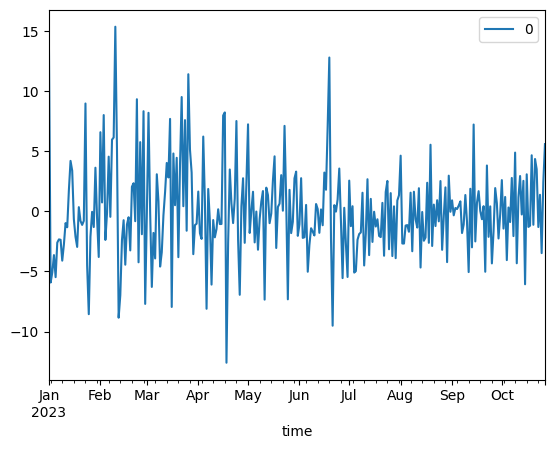

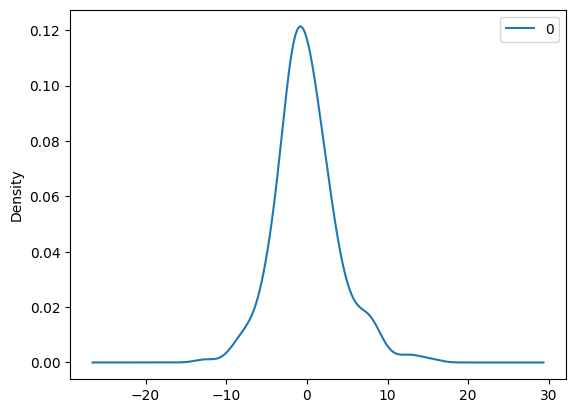

                0
count  300.000000
mean    -0.020348
std      3.864316
min    -12.593939
25%     -2.265726
50%     -0.364285
75%      1.865431
max     15.360808


In [57]:
residuals = pd.DataFrame(model_results.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# Reference

![VAR Forecasting](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/#google_vignette)

![Aritma Forecasting](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#google_vignette)